In [1]:
import torch.nn as nn
import torch
import torchvision
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import argparse
import logging
import sys
from torch import optim
from pathlib import Path
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import numpy as np
import scipy.io as io
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import GPT2Config, GPT2Model
from tqdm.notebook import tqdm
import os.path
from sklearn.model_selection import KFold
import pickle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/research/junbo.s/.conda/envs/new_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
num_of_filter = 64
num_of_wavelength = 250

file_name = '../resampled_2x5_cross_validation'
if os.path.isfile(file_name+'.pickle'): 
    with open(file_name+'.pickle', 'rb') as handle:
        train_folds,test_folds = pickle.load(handle)  



In [3]:
import transformer_lstr as tr
import math

class transformer_cfg():
    def __init__(self,
                 input_len=64,
                 d_model=64,
                 num_heads=2,
                 dim_feedforward=256,
                 dropout=0.3,
                 activation='relu',
                 num_classes=num_of_wavelength
                 ):
        super(transformer_cfg, self).__init__()
        # Transformer configs
        self.input_len = input_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.activation = activation
        self.num_classes = num_classes


class feature_encoder_1d(nn.Module):
    def __init__(self, cfg):
        super(feature_encoder_1d, self).__init__()
        self.input_len = cfg.input_len
        self.d_model = cfg.d_model
        self.feature_encoder = nn.Sequential(
            # nn.Linear(self.input_len, self.input_len * self.d_model*2),
            # nn.Sigmoid(),
            # nn.Linear(self.d_model*self.input_len*2, self.input_len * self.d_model)
            nn.Linear(self.input_len, self.input_len * self.d_model)
        )

    def forward(self, encoded_features):
        _b, _l, _c = encoded_features.shape
        # assert _l == self.input_len and _c == 1
        encoded_features = encoded_features.flatten(1, 2)  # (Bx64x1) -> (Bx64)
        encoded_features = self.feature_encoder(encoded_features)  # (B x 64) -> (B x 64*d_model)
        encoded_features = encoded_features.view(_b, _l, self.d_model)  # (B x 64*d_model32) -> (Bx64xd_model32)
        return encoded_features

class feature_encoder_1d_2(nn.Module):
    def __init__(self, cfg):
        super(feature_encoder_1d_2, self).__init__()
        self.input_len = num_of_wavelength
        self.d_model = cfg.d_model
        self.feature_encoder = nn.Sequential(

            nn.Linear(self.input_len, self.input_len * self.d_model)
        )

    def forward(self, encoded_features):
        _b, _l, _c = encoded_features.shape
        # assert _l == self.input_len and _c == 1
        encoded_features = encoded_features.flatten(1, 2)  # (Bx64x1) -> (Bx64)
        encoded_features = self.feature_encoder(encoded_features)  # (B x 64) -> (B x 64*d_model)
        encoded_features = encoded_features.view(_b, _l, self.d_model)  # (B x 64*d_model32) -> (Bx64xd_model32)
        return encoded_features

class GPT2SpectrumLayer(nn.Module):
    def __init__(self, cfg):
        super(GPT2SpectrumLayer, self).__init__()

        self.training = False

        #self.feature_encoder = feature_encoder_1d(cfg)
        self.feature_encoder2 = feature_encoder_1d_2(cfg)
        self.pos_encoding = tr.PositionalEncoding(cfg.d_model, cfg.dropout)
        #self.pos_encoding2 = tr.PositionalEncoding(cfg.d_model, cfg.dropout)
        #self.keys = nn.Parameter(torch.rand((1, cfg.input_len, cfg.d_model)))
        #self.trainable_embeddings = nn.Parameter(torch.rand((251, cfg.d_model)))
        gpt2_config2 = GPT2Config(
            vocab_size=cfg.num_classes,
            n_positions=num_of_wavelength,
            n_ctx=num_of_wavelength,
            n_embd=cfg.d_model,
            n_layer=4,
            n_head=cfg.num_heads,
            n_inner=cfg.dim_feedforward,
            activation_function="gelu_new",
            resid_pdrop=cfg.dropout,
            embd_pdrop=cfg.dropout,
            attn_pdrop=cfg.dropout,
        )

        self.gpt2_model2 = GPT2Model(config=gpt2_config2)

        self.feature_decoder = nn.Sequential(
            #nn.Linear(cfg.d_model * 251, cfg.d_model * 251),
            #nn.Sigmoid(),
            #nn.Dropout(p=cfg.dropout),
            nn.Linear(cfg.d_model * num_of_wavelength, cfg.d_model * num_of_wavelength),
            nn.Sigmoid(),
            nn.Linear(cfg.d_model * num_of_wavelength, cfg.num_classes),
            nn.Sigmoid(),
        )

    def create_keys(self, keys, encoded_features):
        _l, _b, _c = encoded_features.shape
        keys = keys.expand(_b, -1, -1)
        return keys

    def forward(self, encoded_features):
        #pad (B x 64) -> (B x 251)
        padded_features = F.pad(encoded_features, (0, 0, 0, num_of_wavelength-64))

        features  = self.feature_encoder2(padded_features) # (B x 251) -> (B x 251*d_model32)
        features = features.transpose(0, 1) # (Bx251xd_model32) -> (251xBxd_model32)

        pos_features = self.pos_encoding(features) # (251xBxd_model32)

        #emb = features + pos_features
        emb = pos_features
        output2 = self.gpt2_model2(inputs_embeds = emb.transpose(0,1), past_key_values=None)

        spectrum = output2.last_hidden_state
        spectrum = spectrum.flatten(1, 2)
        spectrum = self.feature_decoder(spectrum)

        return spectrum[:, :, None]


class SpectrumTransformer(nn.Module):
    def __init__(self):
        super(SpectrumTransformer, self).__init__()

        self.cfg_layer3 = transformer_cfg(num_classes=num_of_wavelength)

        # self.tr3 = SpectrumTransformerLayer(self.cfg_layer3) ,Original Transformer
        self.tr3 = GPT2SpectrumLayer(self.cfg_layer3)

    def forward(self, encoded_features):

        if self.training:
            encoded_features = encoded_features + torch.randn_like(encoded_features) * 0.001
        else:
            # print('+')
            pass
        spectrum = self.tr3(encoded_features)
        return spectrum
###########################################
class XSigmoidLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        # return torch.mean(2 * ey_t / (1 + torch.exp(-ey_t)) - ey_t)
        return torch.mean(2 * ey_t * torch.sigmoid(ey_t) - ey_t)

In [4]:
class CalculateMSE():
    def __init__(self, net, n_epochs, batch_size):
        super().__init__()
        self.net = SpectrumTransformer().to(device)
        # initialize some constants
        self.batch_size = batch_size
        self.learning_rate = 1e-4
        self.n_epochs = n_epochs
        self.net.apply(self.weights_init)
        self.device = device

    def weights_init(self, layer):
        if type(layer) == nn.Linear:
            nn.init.orthogonal_(layer.weight)

    def get_mse(self, train_data, train_label, test_data, test_label):
        train_set = torch.utils.data.TensorDataset(
            torch.Tensor(train_data),
            torch.Tensor(train_label))
        val_set = torch.utils.data.TensorDataset(
            torch.Tensor(test_data),
            torch.Tensor(test_label))
        loader_args = dict(batch_size=self.batch_size)
        train_loader = DataLoader(train_set, shuffle=True, drop_last=True, **loader_args)
        val_loader = DataLoader(val_set, shuffle=True, drop_last=True, **loader_args)
        tloss = []
        vloss = []
        criterion = nn.MSELoss()
        # criterion = XSigmoidLoss()
        optimizer = optim.Adam(self.net.parameters(), lr=self.learning_rate)  # weight_decay=0
        for epoch in range(0, self.n_epochs):
            epoch_train_loss = []
            self.net.train()
            for i, data in enumerate(train_loader, 0):
                inputs, label = data
                y_pred = self.net(inputs.to(self.device).unsqueeze(2))
                loss = criterion(y_pred, label.to(self.device).unsqueeze(2))
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                epoch_train_loss.append(loss.item())
            tloss.append(np.mean(epoch_train_loss))
            epoch_loss = []
            self.net.eval()
            for i, data in enumerate(val_loader, 0):
                with torch.no_grad():
                    inputs1, label1 = data
                    y_pred1 = self.net(inputs1.to(self.device).unsqueeze(2))
                    loss1 = criterion(y_pred1, label1.to(self.device).unsqueeze(2))
                    epoch_loss.append(loss1.item())
            vloss.append(np.mean(epoch_loss))

        # Delete the optimizer
        optimizer = None

        return np.min(vloss), self.net


In [5]:
from pathlib import Path

n_epochs=3000
batch_size=32
PATH = '../saved_model/GPT2_combined_poisson_30percent/'
Path(PATH).mkdir(parents=True, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

losses = []
def add_noise(inputs,inputs2, a = 0.02, std = 0.02, sequence_length=64, noise_seed=None):
    if noise_seed is not None:
        np.random.seed(noise_seed)
    noise = np.random.normal(0,std, size = (inputs.shape[0], sequence_length)).astype(np.float32)
    noise2 = np.random.normal(0,std, size = (inputs2.shape[0], sequence_length)).astype(np.float32)
    #noise = poisson.rvs(mu, size=(inputs.shape[0], sequence_length)).astype(np.float32)
    
    nsd = a*np.random.poisson(inputs/a).astype(np.float32)
    nsd2 = a*np.random.poisson(inputs2/a).astype(np.float32)
    
    # Calculate the absolute error between nsd and original inputs
    absolute_error = np.abs(nsd - inputs)
    absolute_error2 = np.abs(nsd2 - inputs2)
    # Sum up the absolute errors
    total_error = np.sum(absolute_error)
    total_error2 = np.sum(absolute_error2)
    # Sum of the original data
    total_original = np.sum(inputs)
    total_original2 = np.sum(inputs2)

    # Calculate the noise ratio
    noise_ratio = (total_error+total_error2) / (total_original+total_original2)
    
    return nsd, nsd2, noise_ratio
for i,(train,test) in enumerate(zip(train_folds,test_folds)):
    train_data, train_label= train[0],train[1]
    test_data, test_label= test[0],test[1]
    train_data,test_data,noise_ratio = add_noise(train_data,test_data, a=0.058,std = 0.05, sequence_length=64, noise_seed=i)
    mse_calculator = CalculateMSE(device,n_epochs,batch_size)
    loss,model = mse_calculator.get_mse(train_data, train_label, test_data, test_label)
    losses.append(loss)
    print(i,loss)
    torch.save(model.state_dict(), PATH+'model'+str(i))
    model.to('cpu')
    model.net = None
    # Empty the CUDA cache
    torch.cuda.empty_cache()
  


0 0.023988551273941994
1 0.028143658861517908
2 0.021948453038930893
3 0.029645968973636628
4 0.019278950430452822
5 0.023566168546676636
6 0.02480112835764885
7 0.026746244728565217
8 0.028184638172388077
9 0.021843840926885606


In [6]:
import numpy as np
print(np.mean(losses),np.std(losses))

0.024814760331064466 0.0031533777216333826


In [7]:
number_figures = 10
import matplotlib.pyplot as plt
model = SpectrumTransformer().to(device)
mdl_name = PATH+'model'+str(9)
model.load_state_dict(torch.load(mdl_name))
model.eval()

for i,(train,test) in enumerate(zip(train_folds,test_folds)):
    train_data, train_label= train[0],train[1]
    test_data, test_label= test[0],test[1]
    indices = torch.randint(0,len(test_data),(number_figures,)).unique()
    for i in indices:
        res = test_data[i].reshape(1,-1,1)
        spec = test_label[i]


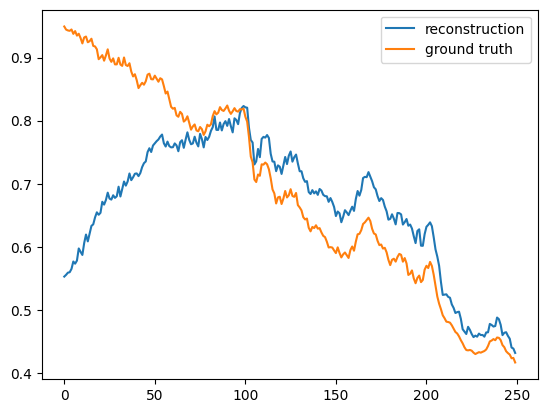

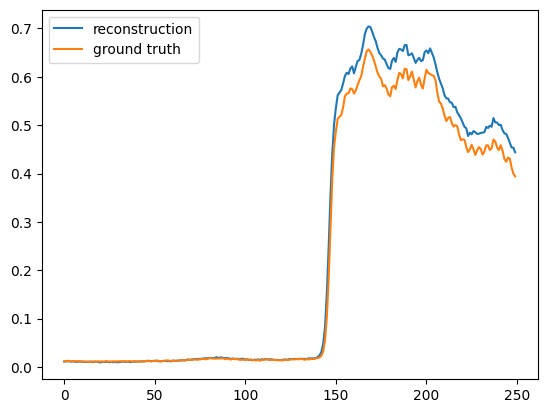

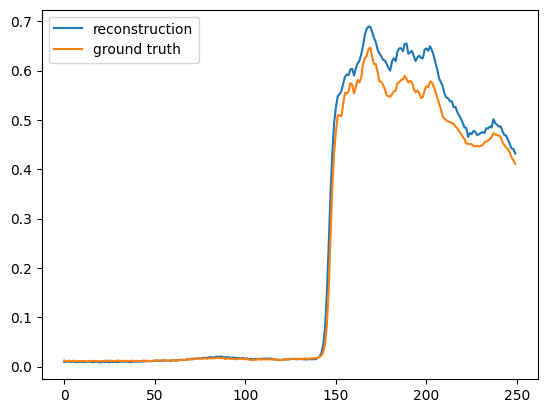

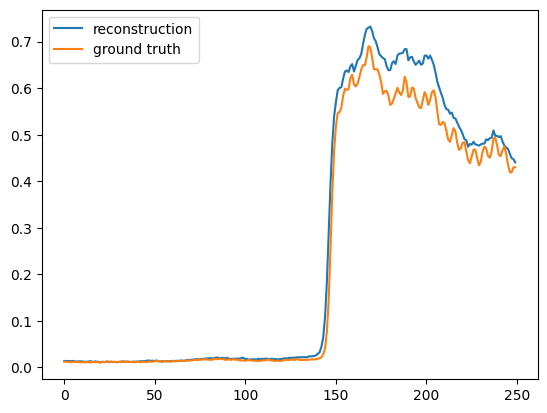

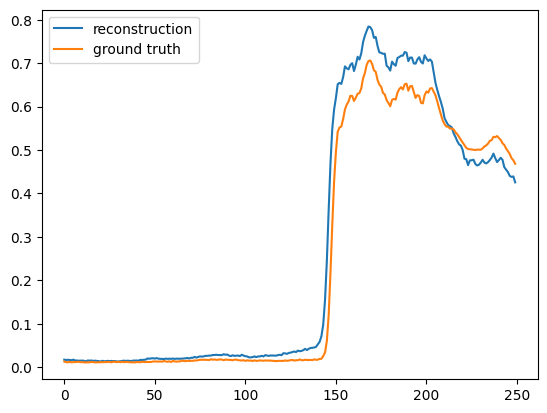

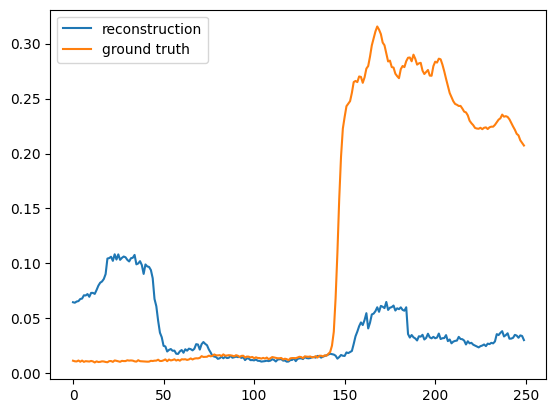

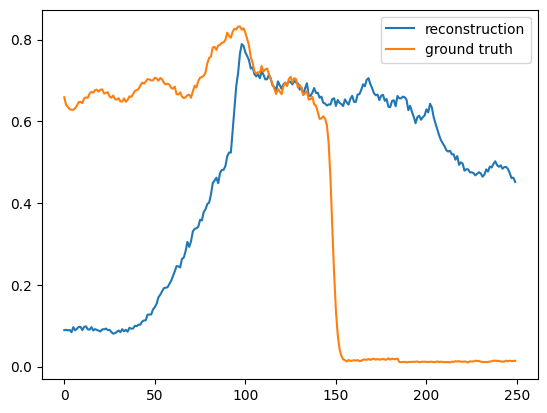

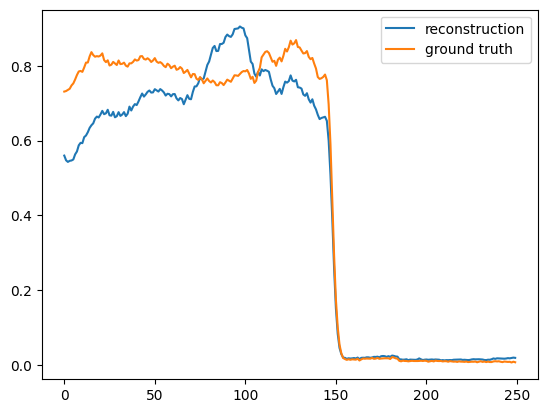

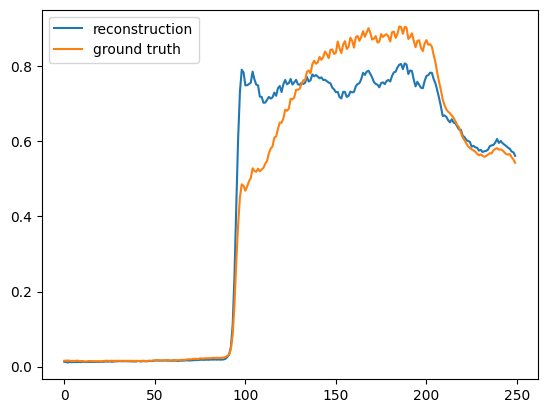

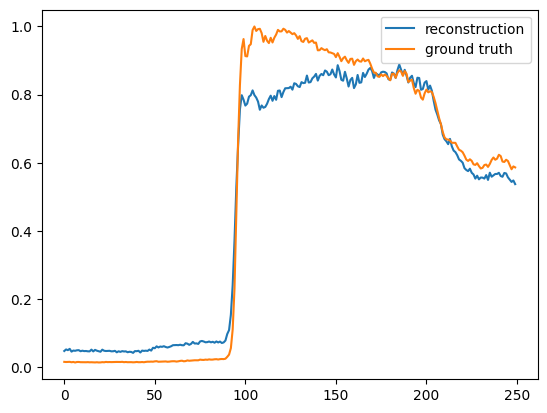

In [8]:
number_figures = 10
import matplotlib.pyplot as plt
model = SpectrumTransformer().to(device)
mdl_name = PATH+'model'+str(9)
model.load_state_dict(torch.load(mdl_name))
model.eval()
indices = torch.randint(0,len(test_data),(number_figures,)).unique()
for i in indices:
    res = test_data[i].reshape(1,-1,1)
    spec = test_label[i]
    plt.figure(i)

    plt.plot(model(torch.Tensor(res).to(device)).detach().cpu().flatten())
    plt.plot(spec)
    plt.legend(['reconstruction','ground truth'])

In [9]:
from scipy import stats,spatial
from dtw import *
import torch
import numpy as np
import dcor
correlation_losses = []

def calculate_correlation(model, test_data, test_label):
    test_data_tensor = torch.tensor(test_data, dtype=torch.float32).unsqueeze(2).to(device)
    construction = model(test_data_tensor).squeeze(2).detach().cpu().numpy()
   
    # Pearson
    pearson_coefs = []
    pearson_ps = []
    
    # Kendall
    kendall_coefs = []
    kendall_ps = []
    
    # Spearman
    spearman_coefs = []
    spearman_ps = []
    # Distance Correlation
    distance_corr = []
    #DTW distance
    alignment = []

    #absolute_error
    abs_err = []

    for i in range(test_label.shape[0]):
        x1 = construction[i,:]
        x2 = test_label[i,:]
        
        res = stats.pearsonr(x1, x2)
        pearson_coefs.append(res[0])
        pearson_ps.append(res[1])
        
        res = stats.kendalltau(x1, x2)
        kendall_coefs.append(res[0])
        kendall_ps.append(res[1])
        
        res = stats.spearmanr(x1, x2)
        spearman_coefs.append(res[0])
        spearman_ps.append(res[1])
        
        distance_corr.append(dcor.distance_correlation(x1,x2))
        
        alignment.append(dtw(x1, x2, distance_only=True).distance)
        abs_err.append(abs(x1-x2))
        
    correlation_results = {
        'pearson': (pearson_coefs, pearson_ps),
        'kendall': (kendall_coefs, kendall_ps),
        'spearman': (spearman_coefs, spearman_ps),
        'DTW': alignment,
        'Absolute Error': abs_err,
        'Distance Correlation': distance_corr
    }

    return correlation_results


for i,(train,test) in enumerate(zip(train_folds,test_folds)):
    train_data, train_label= train[0],train[1]
    test_data, test_label= test[0],test[1]
    train_data,test_data,noise_ratio = add_noise(train_data,test_data, a=0.058,std = 0.05, sequence_length=64, noise_seed=i)
    mdl_name = PATH + 'model' + str(i)
    model.load_state_dict(torch.load(mdl_name))
    model.eval()
    
    correlation_loss = calculate_correlation(model, test_data, test_label)
    correlation_losses.append(correlation_loss)


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



/home/research/junbo.s/.conda/envs/new_env/lib/python3.10/site-packages/dcor/_fast_dcov_avl.py:554: UserWarning: Falling back to uncompiled AVL fast distance covariance terms because of TypeError exception raised: No matching definition for argument type(s) array(float32, 1d, C), array(float64, 1d, C), bool. Rembember: only floating point values can be used in the compiled implementations.
  warnings.warn(


In [10]:
for key in correlation_losses[0].keys():
    print(key)
    if key=='Absolute Error':
        errors = []
        for d in correlation_losses:
            errors+=np.concatenate(d[key]).ravel().tolist()
        #percentile
        percentiles = [5, 50, 90, 95, 99]
        for p in percentiles:
            print(p)
            print(np.percentile(errors, p))
    else:
        stat, p = [], []
        for d in correlation_losses:
            if key=='DTW' or key=='Distance Correlation':
                stat+=d[key]
            else:
                stat+=d[key][0]
                p+=d[key][1]
        print(np.mean(stat),np.std(stat))
        if len(p)>0:
            print(np.mean(p),np.std(p))


pearson
0.7100223496440053 0.47945806538254315
0.010950687716468718 0.07779868298430766
kendall
0.566979327341539 0.3369137218116101
0.017115566306438287 0.0985689722385995
spearman
0.6766023547997783 0.4270192729868116
0.015531426080017039 0.09123858913007538
DTW
19.05989908861596 25.07090566406844
Absolute Error
5
0.0010840148347741236
50
0.03951574676020114
90
0.3310132278385129
95
0.49692839799805605
99
0.7028996246941633
Distance Correlation
0.8462397396293921 0.20755125124355542
